# Overview

Notebook ini digunakan untuk EDA untuk data [**Online Retail II UCI**](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci)

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

# Import Data

In [2]:
df = pd.read_parquet("data/preprocessed/cleaned_data.parquet") # Load Parquet
df.sample(5) # Preview data

,order_id,sku_id,sku_name,quantity,order_date,sku_price,customer_id,country,order_id_cancelled,order_id_adjustment,sku_id_no_digit
206821,512751,46000M,POLYESTER FILLER PAD 45X45CM,6,2010-06-17 15:08:00,1.55,17953,UNITED KINGDOM,False,False,False
175048,509184,21175,GIN + TONIC DIET METAL SIGN,1,2010-05-20 16:49:00,2.10,16347,UNITED KINGDOM,False,False,False
163203,507560,22299,PIG KEYRING WITH LIGHT & SOUND,24,2010-05-10 12:29:00,1.25,14361,UNITED KINGDOM,False,False,False
938945,577024,21494,ROTATING LEAVES T-LIGHT HOLDER,2,2011-11-17 12:47:00,1.25,14704,UNITED KINGDOM,False,False,False
919484,575695,23323,WHITE WICKER STAR,6,2011-11-10 16:39:00,2.10,17502,UNITED KINGDOM,False,False,False


# Feature Engineering (Part I)

Akan kita coba buat beberapa fitur yang relevan terhadap penjualan, seperti:
- GMV (quantity * sku_price)
- Fitur Waktu (Jam, hari, tanggal, bulan belanja)

In [3]:
df['gmv'] = df['quantity']*df['sku_price'] # gmv
df['order_hour'] = df['order_date'].dt.hour # jam pembelian
df['order_day'] = df['order_date'].dt.day # hari pembelian
df['order_dayofweek'] = df['order_date'].dt.dayofweek + 1 # Monday starts at 0 -> 1
df['order_month'] = df['order_date'].dt.month # Bulan pembelian

# Data Exploration

## Stats Descriptive

In [4]:
# untuk check statistics descriptive (count, mean, min, q1, q2,q3, max, std) pada setiap kolom numeric
df.describe().round(2)

,quantity,order_date,sku_price,customer_id,gmv,order_hour,order_day,order_dayofweek,order_month
count,1002097.00,1002097,1002097.00,775065.0,1002097.00,1002097.00,1002097.00,1002097.00,1002097.00
mean,10.24,2011-01-12 19:43:46.771041024,4.74,15334.1,17.90,13.04,15.13,3.46,7.57
min,-80995.00,2009-12-01 07:45:00,-53594.36,12346.0,-168469.60,6.00,1.00,1.00,1.00
25%,1.00,2010-08-01 15:41:00,1.25,13983.0,3.75,11.00,8.00,2.00,5.00
50%,3.00,2010-12-13 11:21:00,2.10,15272.0,9.90,13.00,15.00,3.00,8.00
75%,10.00,2011-07-31 13:13:00,4.13,16806.0,17.70,15.00,22.00,5.00,11.00
max,80995.00,2011-12-09 12:50:00,38970.00,18287.0,168469.60,21.00,31.00,7.00,12.00
std,171.20,NaN,127.40,1696.79,298.81,2.43,8.68,1.88,3.51


- Kita punya 2 tahun data (2009 - 2011) cukup untuk melihat tren tahun ke tahun
- Ada harga yang negatif?
- Quantity negatif (yang berasal dari order yang cancelled)
- sebagian besar data punya low quantity ataupun low price
- Ada right skewness (sebagian besar data punya value kecil, namun ada beberapa value ekstrim), dapat dilihat dari median yang lebih kecil dari mean

In [5]:
# Cek unique id untuk kolom categorical
for col in ['order_id','sku_id','customer_id','country']:
    print(f'unique value {col}:',df[col].nunique())

unique value order_id: 48018
unique value sku_id: 4787
unique value customer_id: 5931
unique value country: 43


In [6]:
# Cek untuk sku price negatif
df[df['sku_price']<0]

,order_id,sku_id,sku_name,quantity,order_date,sku_price,customer_id,country,order_id_cancelled,order_id_adjustment,sku_id_no_digit,gmv,order_hour,order_day,order_dayofweek,order_month
152714,A506401,B,ADJUST BAD DEBT,1,2010-04-29 13:36:00,-53594.36,<NA>,UNITED KINGDOM,False,True,True,-53594.36,13,29,4,4
237485,A516228,B,ADJUST BAD DEBT,1,2010-07-19 11:24:00,-44031.79,<NA>,UNITED KINGDOM,False,True,True,-44031.79,11,19,1,7
355106,A528059,B,ADJUST BAD DEBT,1,2010-10-20 12:04:00,-38925.87,<NA>,UNITED KINGDOM,False,True,True,-38925.87,12,20,3,10
766792,A563186,B,ADJUST BAD DEBT,1,2011-08-12 14:51:00,-11062.06,<NA>,UNITED KINGDOM,False,True,True,-11062.06,14,12,5,8
766793,A563187,B,ADJUST BAD DEBT,1,2011-08-12 14:52:00,-11062.06,<NA>,UNITED KINGDOM,False,True,True,-11062.06,14,12,5,8


Untuk SKU price yang negatif, kita dapat drop data tersebut

In [7]:
# Drop data yang price nya negatif
df = df[df['sku_price']>0]

# Missing Value Analysis

Secara sekilas, kita dapat melihat missing value dengan:

In [8]:
# hitung persentase null values per kolom dibandingkan dengan jumlah data
df.isnull().sum()/len(df)

order_id               0.000000
sku_id                 0.000000
sku_name               0.000000
quantity               0.000000
order_date             0.000000
sku_price              0.000000
customer_id            0.225926
country                0.000000
order_id_cancelled     0.000000
order_id_adjustment    0.000000
sku_id_no_digit        0.000000
gmv                    0.000000
order_hour             0.000000
order_day              0.000000
order_dayofweek        0.000000
order_month            0.000000
dtype: float64

Pada kasus ini, setelah pengolahan data yang ada di part 1, missing value yang tersisa hanya ada di customer_id

Untuk menghandle missing value, ada beberapa hal yang bisa dicoba:
- Drop missing value (Jika tidak terlalu banyak informasi yang hilang)
- Imputasi (Perlu dicek apakah missing valuenya sistemik, ex: hanya muncul di grup tertentu)
- Ignore

**Dalam kasus ini**, karena missing value cukup banyak 22%, maka kita tidak melakukan drop missing value <br> Untuk imputasi pun juga tidak makes sense, karena ini merupakan ID <br> Jadi kita dapat ignore missing value tersebut

**Catatan**: jika anda menemukan missing value, banyak metode untuk mengimputasinya, seperti fill dengan median (numerik, ordinal), modus (nominal). Ataupun dengan imputasi multivariate seperti metode MICE

# Visualization (Part 1)

Untuk mendapatkan sense dari data, maka diperlukan visualisasi, mari kita cek distribusi dari masing masing kolom

In [9]:
# Group for categorical (ordinal)
cat_cols = ['order_hour','order_day','order_dayofweek','order_month'] 

# Numerical data
num_cols = ['quantity','sku_price','gmv']

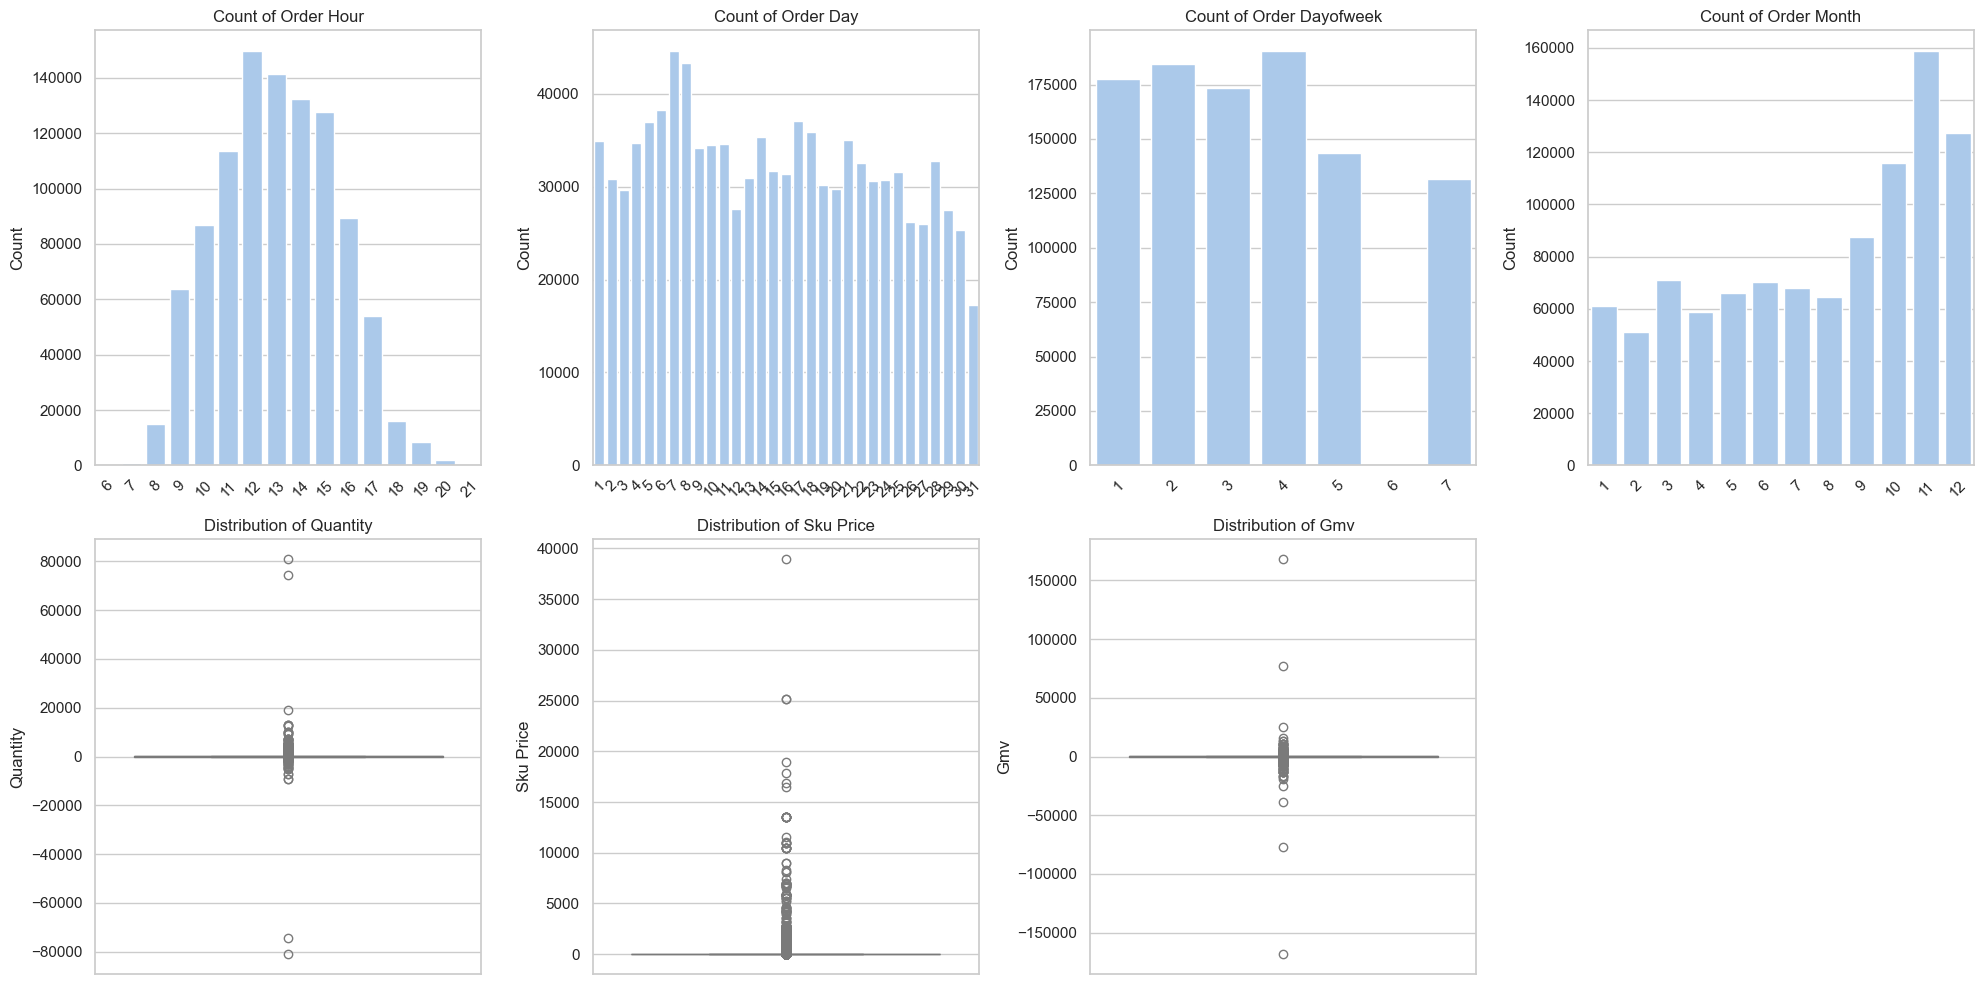

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # 2 row x 4 columns untuk setiap kolom

# Row 1: row categorical, countplots
for ax, col in zip(axes[0], cat_cols): # loop plot utk setiap kolom categorical
    sns.countplot(x=col, data=df, ax=ax) # Countplot
    ax.set_title(f"Count of {col.replace('_',' ').title()}") # Replace nama "_" di nama kolom menjadi spasi dan ubah menjadi title format
    ax.set_xlabel('') # set blank xlabel
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45) # Rotate untuk visibility

# Row 2: row numeric, boxplots
for ax, col in zip(axes[1], num_cols): # loop plot utk setiap kolom numerical
    sns.boxplot(y=col, data=df, ax=ax) # Boxplot
    ax.set_title(f"Distribution of {col.replace('_',' ').title()}") # Replace nama "_" di nama kolom menjadi spasi dan ubah menjadi title format
    ax.set_xlabel('') # set blank xlabel
    ax.set_ylabel(col.replace('_',' ').title())

fig.delaxes(axes[1,-1]) # hapus subplot terakhir karena kosong
    
plt.tight_layout()
plt.show()

Key Insight:
- Kita bisa lihat 'jam buka' retail pada jam 8 pagi sampai 8 malam, dengan pembelian terbanyak di siang hari
- Untuk tanggal belanja, kebanyakan pembelian ada di awal bulan, dan perlahan menurun
- Pembelian terbanyak ada di hari kamis, dan ternyata toko ini libur saat hari sabtu
- Untuk bulan belanja, terbanyak pada akhir tahun
- Karena outlier, kita bahkan tidak dapat melihat distribusi dari quantity, price, dan gmv

Outlier tersebut dapat mempengaruhi analisa, jadi mesti kita handle

# Outlier Handling

Karena gmv merupakan produk dari quantity*price, kita cukup fokus menganalisa quantity dan price saja

Secara statistik, Outlier Detection dapat dilakukan dengan beberapa cara:
- Univariate
- Multivariate 

Univariate hanya memperhatikan kolom yang difokuskan, sedangkan Multivariate memperhatikan relasi terhadap kolom lainnya <br> Contoh simplenya: barang dengan gmv tinggi bisa saja diflag sebagai outlier dengan deteksi univariate, namun jika quantity penjualannya juga tinggi, seharusnya fair fair saja kalau gmv nya juga tinggi, tidak terdeteksi outlier secara multivariate

Contoh metode yang dapat digunakan adalah <br>
Untuk Univariate:
- Z-score (Standardize the data, kurangi mean $\mu$ dan dibagi standard deviation $\sigma$)
- IQR Bound (Hitung IQR = Quartile 3 ($Q_3$) - Quartile 1 ($Q_1$), lalu flag data yang diatas $Q_3 + k*IQR$ atau dibawah $Q_1 - k*IQR$

What works best? 
- Z-score menggunakan $\mu$ dan $\sigma$, dua *central tendency* yang tidak robust terhadap outlier, gunakan Z-score jika data anda tidak skewed (works best on approximately normal data)
- IQR Bound menggunakan percentile, yang cukup robust terhadap outlier

Untuk Multivariate:
- Gunakan metode anomaly detection seperti **Isolation Forest**, **DBScan** untuk menemukan outlier

## Outlier detection dengan IQR

In [11]:
# Hitung q1 dan q3 untuk quantity
Q1_qty, Q3_qty = df['quantity'].quantile([0.25, 0.75])
IQR_qty = Q3_qty - Q1_qty
# Hitung q1 dan q3 untuk sku_price
Q1_price, Q3_price = df['sku_price'].quantile([0.25, 0.75])
IQR_price = Q3_price - Q1_price

# Hitung lower dan upper limit utk quantity
lower_qty = Q1_qty - 5 * IQR_qty
upper_qty = Q3_qty + 5 * IQR_qty

# Hitung lower dan upper limit utk price
lower_price = Q1_price - 5 * IQR_price
upper_price = Q3_price + 5 * IQR_price


print(f"Quantity outlier bounds: [{lower_qty:.2f}, {upper_qty:.2f}]")
print(f" SKU Price outlier bounds: [{lower_price:.2f}, {upper_price:.2f}]\n")

# Memberikan flag untuk masing2 kolom yang diluar upper & lower limit
df['outlier_qty'] = (df['quantity'] < lower_qty) | (df['quantity'] > upper_qty)
df['outlier_price'] =  (df['sku_price'] < lower_price) | (df['sku_price'] > upper_price)
# Buat kolom flag outlier (kalau qty atau price outlier maka flag True)
df['outlier_flag'] = df['outlier_qty'] | df['outlier_price']

Quantity outlier bounds: [-44.00, 55.00]
 SKU Price outlier bounds: [-13.15, 18.53]



Step selanjutnya adalah, mengecek kenapa data tersebut outlier, apakah ada tanggal tanggal tertentu?

### Previous Visualization on Outlier only

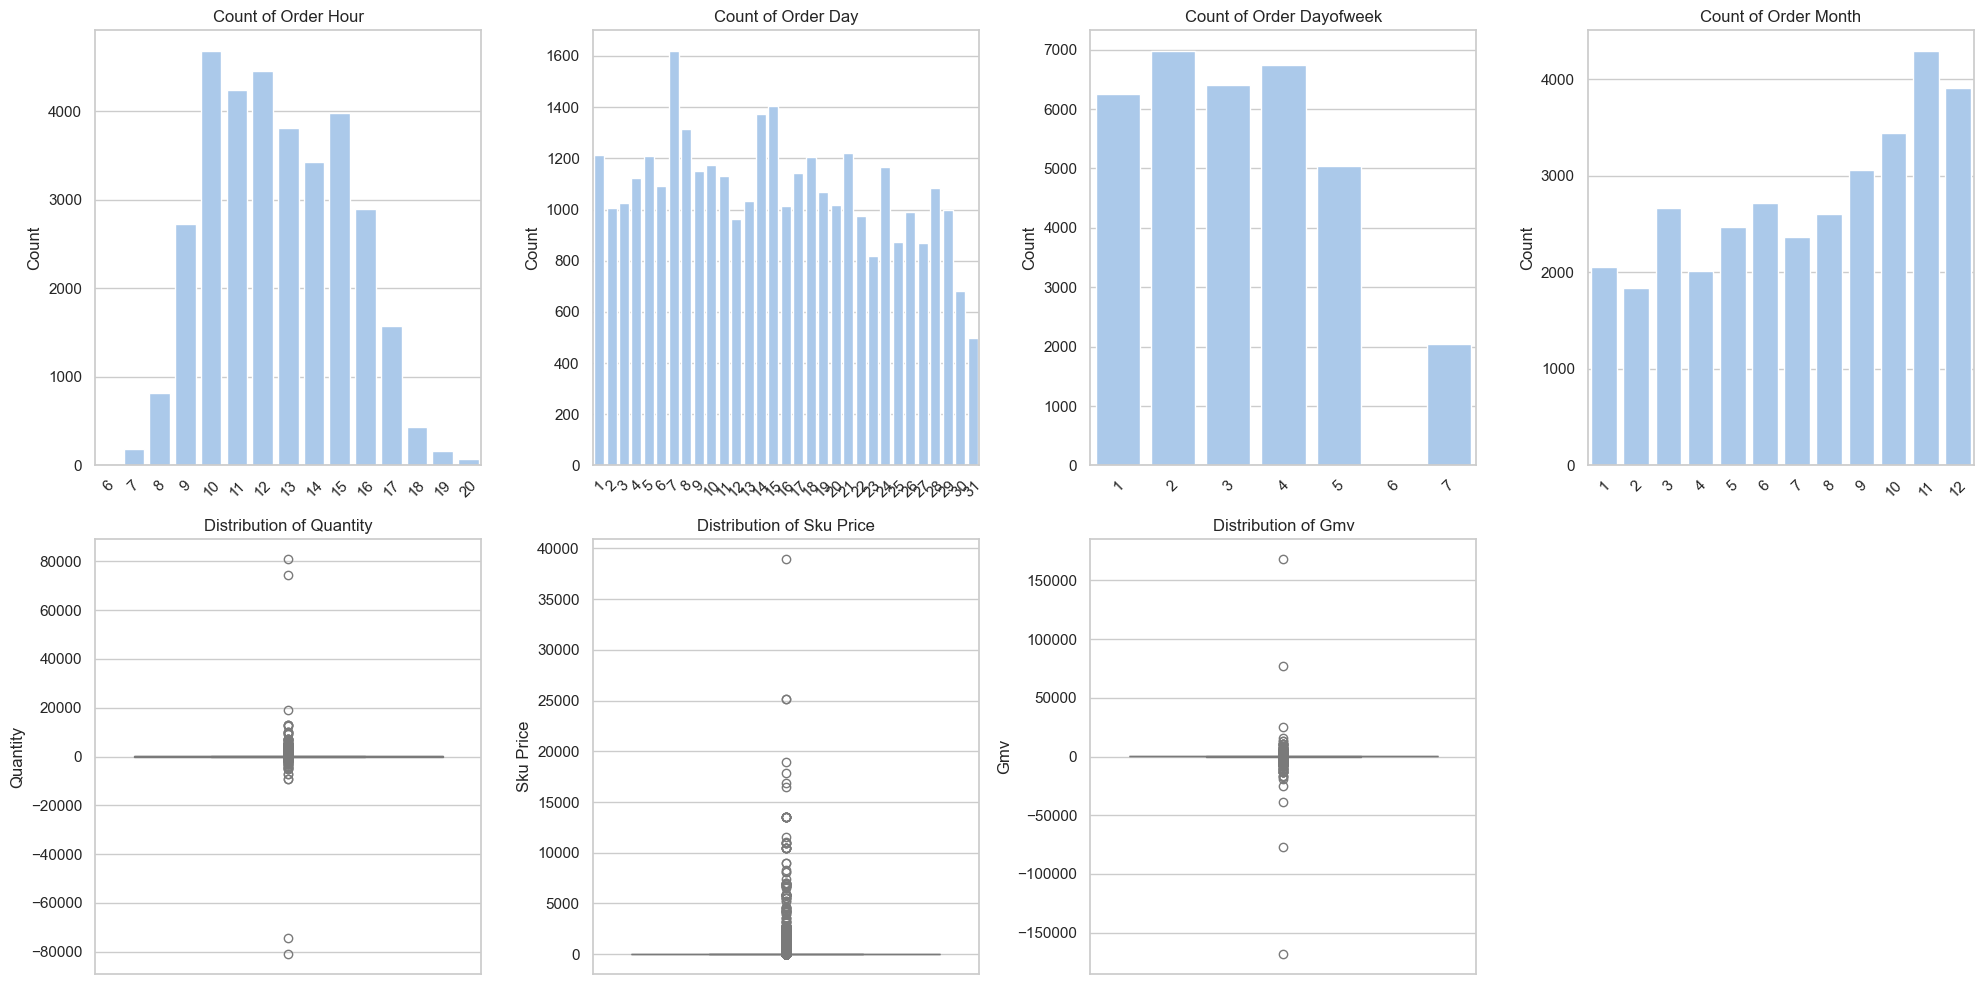

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # 2 row x 4 columns untuk setiap kolom

# Row 1: row categorical, countplots
for ax, col in zip(axes[0], cat_cols): # loop plot utk setiap kolom categorical
    sns.countplot(x=col, data=df[df['outlier_flag']], ax=ax) # Countplot
    ax.set_title(f"Count of {col.replace('_',' ').title()}") # Replace nama "_" di nama kolom menjadi spasi dan ubah menjadi title format
    ax.set_xlabel('') # set blank xlabel
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45) # Rotate untuk visibility

# Row 2: row numeric, boxplots
for ax, col in zip(axes[1], num_cols):  # loop plot utk setiap kolom numerical
    sns.boxplot(y=col, data=df[df['outlier_flag']], ax=ax) # Boxplot
    ax.set_title(f"Distribution of {col.replace('_',' ').title()}") # Replace nama "_" di nama kolom menjadi spasi dan ubah menjadi title format
    ax.set_xlabel('') # set blank xlabel
    ax.set_ylabel(col.replace('_',' ').title())

fig.delaxes(axes[1,-1]) # hapus subplot terakhir karena kosong
    
plt.tight_layout()
plt.show()

Tidak terlihat pattern tertentu untuk tanggal pembelian

### Previous Visualization on Non Outlier

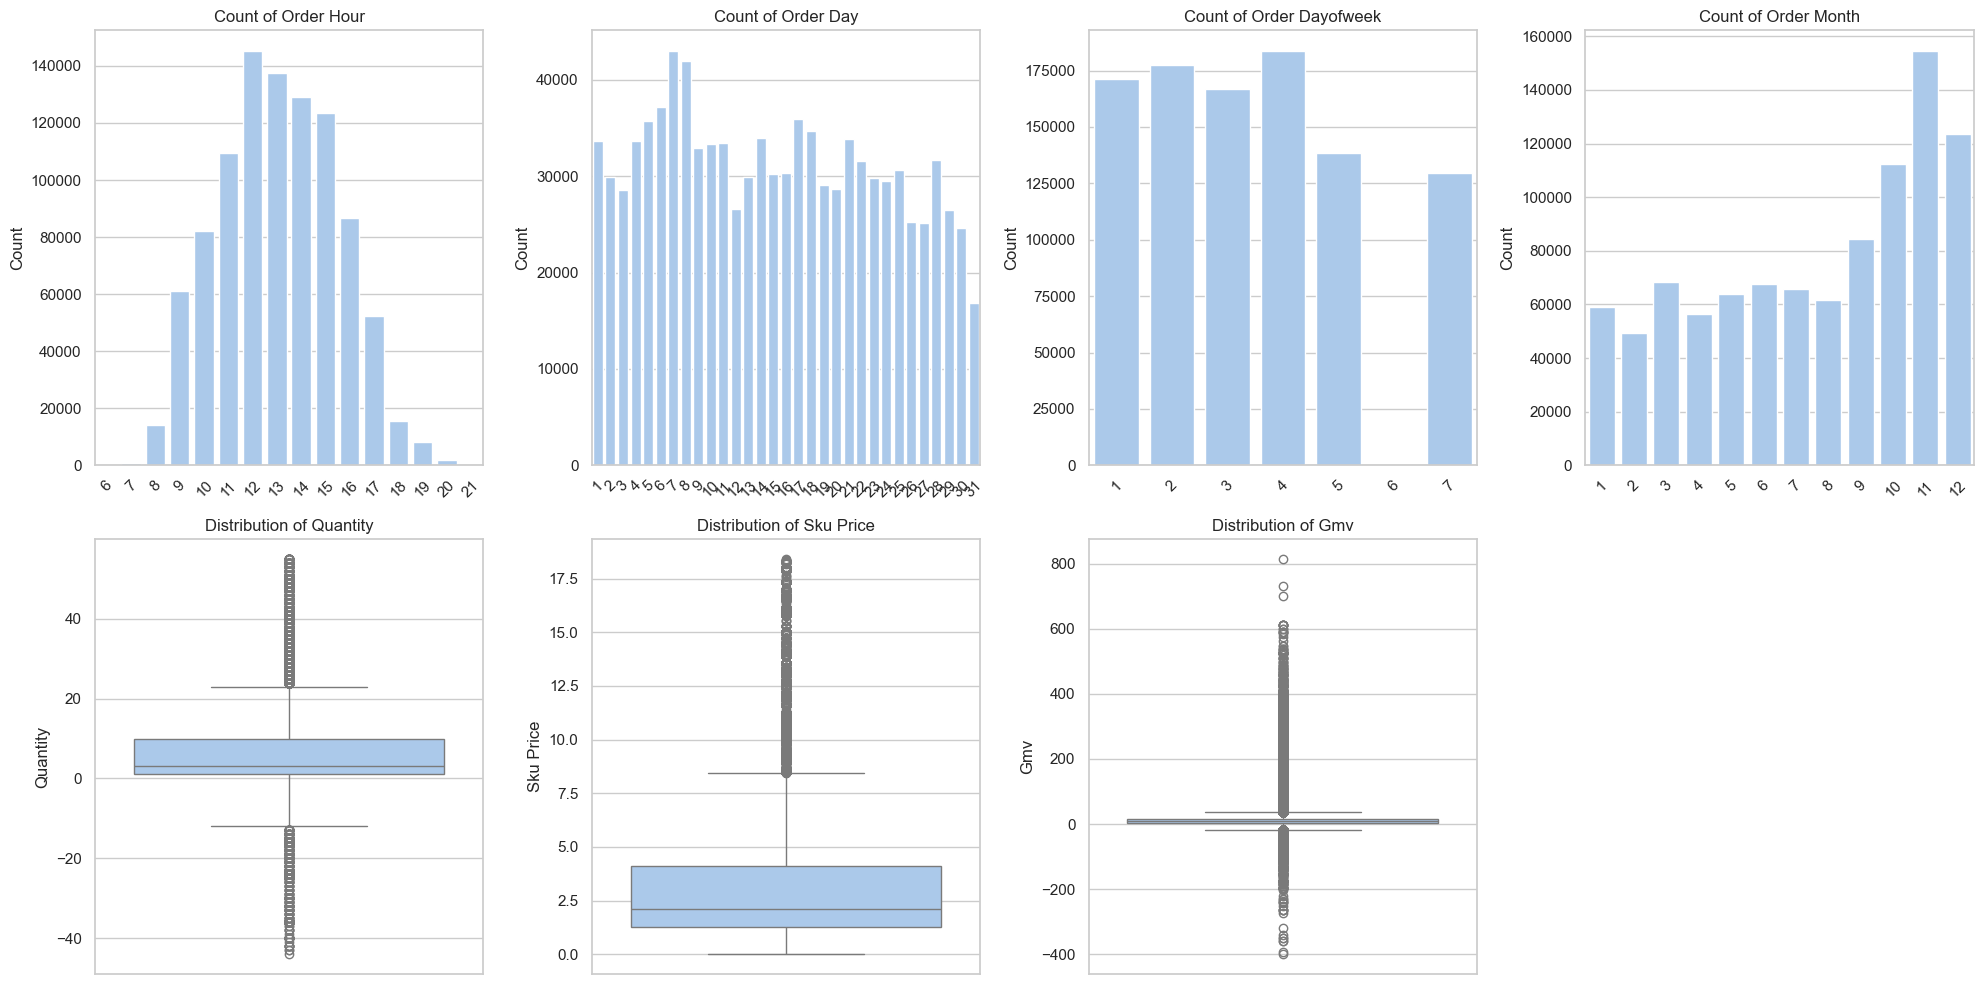

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # 2 row x 4 columns untuk setiap kolom

# Row 1: row categorical, countplots
for ax, col in zip(axes[0], cat_cols): # loop plot utk setiap kolom categorical
    sns.countplot(x=col, data=df[~df['outlier_flag']], ax=ax) # Countplot
    ax.set_title(f"Count of {col.replace('_',' ').title()}")
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45) # Rotate untuk visibility

# Row 2: row numeric, boxplots
for ax, col in zip(axes[1], num_cols): # loop plot utk setiap kolom numerical
    sns.boxplot(y=col, data=df[~df['outlier_flag']], ax=ax) # Boxplot
    ax.set_title(f"Distribution of {col.replace('_',' ').title()}")
    ax.set_xlabel('')
    ax.set_ylabel(col.replace('_',' ').title())

fig.delaxes(axes[1,-1])
    
plt.tight_layout()
plt.show()

Setelah memfokuskan pada non-outlier, kita sedikit bisa melihat distribusi dari quantity dan sku price

## What to explore next?

Dari data ini saja, sudah banyak possibility untuk eksplorasi, misal:
- Apakah dari data outlier tersebut, dilakukan oleh customer yang sama? (Ada Bulk Buyer, bahkan fraud?)
- Apakah outlier tersebut dimunculkan karena kesalahan input?
- Apakah terdapat produk yang harganya tiba tiba naik?

## Bulk Buyer

In [14]:
high_quantity_purchase = df[df['outlier_qty']] # Cek data outlier_qty
high_quantity_purchase_customer = high_quantity_purchase[['customer_id']].drop_duplicates() # Buat list customer yang memiliki pembelian outlier
high_quantity_purchase_customer['have_high_quantity_purchase'] = True # beri flag untuk customer yang mempunyai pembelian tinggi

In [15]:
purchase_per_customer = df.groupby('customer_id').agg({'quantity':'mean'}).reset_index().rename(columns={'quantity':'average_quantity'}) # hitung average qty pembelian tiap customer
purchase_per_customer = purchase_per_customer.merge(high_quantity_purchase_customer,on='customer_id',how='left') # Join dengan list customer yang memiliki pembelian tinggi
purchase_per_customer['have_high_quantity_purchase'] = purchase_per_customer['have_high_quantity_purchase'].fillna(False) # Fillna dgn False utk customer yang tidak memiliki pembelian tinggi

C:\Users\PC\AppData\Local\Temp\ipykernel_9180\1812712610.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  purchase_per_customer['have_high_quantity_purchase'] = purchase_per_customer['have_high_quantity_purchase'].fillna(False) # Fillna dgn False utk customer yang tidak memiliki pembelian tinggi


In [16]:
purchase_per_customer[purchase_per_customer['have_high_quantity_purchase']] # cek customer yang memiliki pembelian tinggi

,customer_id,average_quantity,have_high_quantity_purchase
0,12346,1.133333,True
1,12347,13.157895,True
2,12348,55.041667,True
9,12355,15.514286,True
10,12356,23.894366,True
...,...,...,...
5911,18271,15.190476,True
5913,18273,35.000000,True
5919,18279,48.461538,True
5925,18285,12.083333,True


Ada customer yang biasanya secara rata rata punya 1 pembelian, namun tiba tiba punya pembelian quantity besar, namun ada juga customer yang terbiasa membeli secara grosir (bulk buyer)

Banyak *nuance* yang mesti diselidiki, apakah pembelian itu adalah barang yang murah? atau kah luxury goods? Ini dapat ditelusuri lebih lanjut

## Product Price Checking

Mari kita cek poin terakhir, mungkin outlier nya terjadi karena ada kesalahan di price

In [17]:
# Dapatkan summary min, q1, median, q3, max price per product
product_price_summary = (
    df.groupby(['sku_id','sku_name'])
      .agg(sku_price_min=('sku_price', 'min'),
           sku_price_q1=('sku_price', lambda x: x.quantile(0.25)),
           sku_price_median=('sku_price', 'median'),
           sku_price_q3=('sku_price', lambda x: x.quantile(0.75)),
           sku_price_max=('sku_price', 'max'))
      .reset_index()
)

# Dapatkan ratio nya, sebagai ukuran seberapa jauh nilai maksimum dari median
product_price_summary['max_to_median_ratio'] = product_price_summary['sku_price_max']/product_price_summary['sku_price_median']
product_price_summary.sort_values('max_to_median_ratio',ascending=False).head(10)

,sku_id,sku_name,sku_price_min,sku_price_q1,sku_price_median,sku_price_q3,sku_price_max,max_to_median_ratio
4693,PADS,PADS TO MATCH ALL CUSHIONS,0.001,0.001,0.001,0.001,36.60,36600.000000
4692,M,MANUAL,0.030,1.250,12.750,342.015,38970.00,3056.470588
3442,84016,FLAG OF ST GEORGE CAR FLAG,0.350,0.420,0.420,0.420,1157.15,2755.119048
4694,POST,POSTAGE,0.500,18.000,18.000,18.000,8142.75,452.375000
4666,BANK CHARGES,BANK CHARGES,0.001,15.000,42.120,359.440,18910.69,448.971747
109,17003,BROCADE RING PURSE,0.050,0.210,0.290,0.390,57.60,198.620690
4669,D,DISCOUNT,0.010,9.900,19.000,56.900,1867.86,98.308421
3453,84033,FLAG OF ST GEORGE,1.650,1.650,1.650,1.650,85.10,51.575758
2990,37482P,CUBIC MUG PINK POLKADOT,0.390,0.390,0.390,2.550,16.98,43.538462
2987,37479P,CUBIC MUG FLOCK PINK ON BROWN,0.390,0.390,0.390,2.550,16.98,43.538462


Nah, setelah pengolahan data tadi, sudah terlihat outlier price nya, data data ini yang perlu diperhatikan lebih. Mari kita coba buat threshold untuk adjust price

In [18]:
# hitung iqr price utk setiap product
product_price_summary['sku_price_iqr'] = (
    product_price_summary['sku_price_q3'] - product_price_summary['sku_price_q1']
)
# hitung upper bound price setiap product
product_price_summary['sku_price_upper_bound'] = (
    product_price_summary['sku_price_q3'] + 1.5 * product_price_summary['sku_price_iqr']
)

In [19]:
# Merge dengan df
df = df.merge(product_price_summary[['sku_id','sku_price_upper_bound']])

Selanjutnya, kita dapat men-*capping* sku price, jadi price yang lebih dari upper bound nya akan kita jadikan sesuai dengan upper boundnya

In [20]:
# Beri penanda utk record yang price nya outlier
df['outlier_price'] = df['sku_price'] > df['sku_price_upper_bound']
# Adjust price (cap dengan nilai minimum dari sku_price dan upper_bound)
df['adjusted_price'] = df.apply(lambda x: min(x['sku_price'],x['sku_price_upper_bound']),axis=1)

Karena sudah ada adjusted_price, maka GMV juga perlu di update

In [21]:
# adjust gmv
df['adjusted_gmv'] = df['adjusted_price']*df['quantity']

Untuk quantity, kita tidak dapat menerapkan logic yang serupa (tidak bisa membuat adjusted quantity)

In [22]:
# Update flag outlier
df['outlier_flag'] = df['outlier_price'] | df['outlier_qty']

Setelah melakukan outlier handling, akhirnya kita bisa lanjut analisa yang lebih dalam dan menemukan insight insight menarik

# Visualization (Part 2)

## Pareto Analysis
Salah satu hal yang biasanya jadi point of interest adalah: 
- Produk mana saja yang jadi produk pareto kita
- Region (country) mana saja yang merupakan kontributor terbesar
- Apakah ada customer dengan kontribusi yang signifikan?

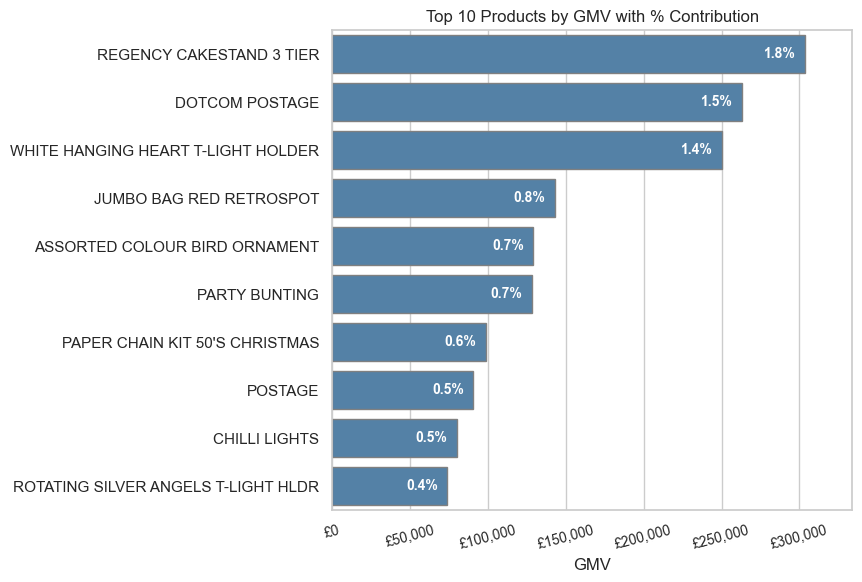

In [23]:
# Ambil sales per product menggunakan adjusted gmv
per_product_sales = (
    df.groupby('sku_name')
      .agg(gmv=('adjusted_gmv', 'sum'))
      .reset_index()
)
# Hitung total gmv
total_gmv = per_product_sales['gmv'].sum()

# Hitung persentase kontribusi ke total
per_product_sales['pct'] = per_product_sales['gmv'] / total_gmv * 100

# Ambil top 10
per_product_sales = (
    per_product_sales
      .sort_values('gmv', ascending=False)
      .head(10)
      .reset_index(drop=True)
)

# Plot dalam horizontal bar chat (x = gmv, y = sku_name)
fig, ax = plt.subplots(figsize=(8, 6))
bars = sns.barplot(
    data=per_product_sales,
    x='gmv',
    y='sku_name',
    color='steelblue',
    ax=ax,
    edgecolor='gray'
)

# Axis formatting
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}'))
ax.tick_params(axis='x', labelsize=10, rotation=15)
ax.set_xlabel('GMV')
ax.set_ylabel('')
ax.set_title('Top 10 Products by GMV with % Contribution')

# Extend x‑limit untuk label
max_gmv = per_product_sales['gmv'].max()
ax.set_xlim(0, max_gmv * 1.1)

# Annotate persentase kontribusi ke masing masing bar chart
for bar, pct in zip(ax.patches, per_product_sales['pct']):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(
        width - (max_gmv * 0.02), 
        y,
        f"{pct:.1f}%",
        ha='right',
        va='center',
        color='white',
        fontsize=10,
        fontweight='bold'
    )

# Adjustment margin
fig.subplots_adjust(left=0.30, right=0.95, top=0.90, bottom=0.10)

plt.show()


Produk dengan kontribusi sales terbesar hanya menyumbang 1.8% dari total GMV, ini mengartikan tidak ada produk yang dominan

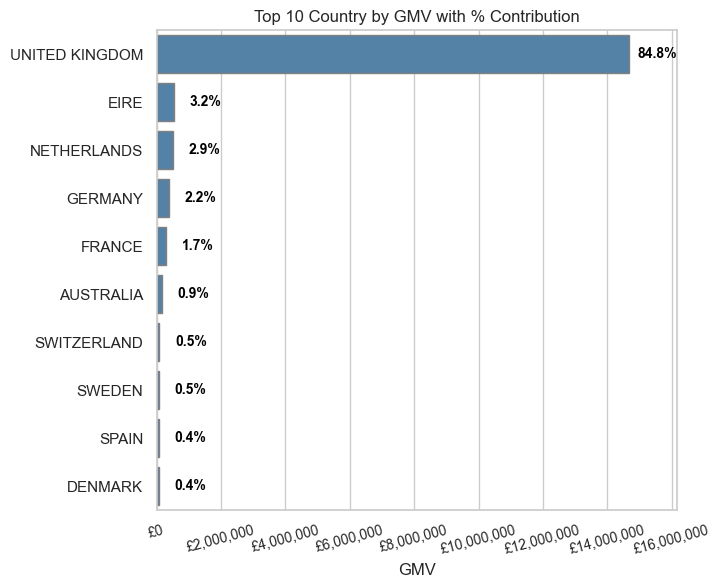

In [24]:
# Ambil sales per country menggunakan adjusted gmv
per_country_sales = (
    df.groupby('country')
      .agg(gmv=('adjusted_gmv', 'sum'))
      .reset_index()
)
# Hitung total gmv
total_gmv = per_country_sales['gmv'].sum()

# Hitung persentase kontribusi ke total
per_country_sales['pct'] = per_country_sales['gmv'] / total_gmv * 100

# Ambil top 10
per_country_sales = (
    per_country_sales
      .sort_values('gmv', ascending=False)
      .head(10)
      .reset_index(drop=True)
)

# Plot dalam horizontal bar chat (x = gmv, y = sku_name)
fig, ax = plt.subplots(figsize=(8, 6))
bars = sns.barplot(
    data=per_country_sales,
    x='gmv',
    y='country',
    color='steelblue',
    ax=ax,
    edgecolor='gray'
)

# Axis formatting
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}'))
ax.tick_params(axis='x', labelsize=10, rotation=15)
ax.set_xlabel('GMV')
ax.set_ylabel('')
ax.set_title('Top 10 Country by GMV with % Contribution')

# Extend x‑limit untuk label
max_gmv = per_country_sales['gmv'].max()
ax.set_xlim(0, max_gmv * 1.1)

# Annotate persentase kontribusi ke masing masing bar chart
for bar, pct in zip(ax.patches, per_country_sales['pct']):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(
        width + (max_gmv * 0.1), 
        y,
        f"{pct:.1f}%",
        ha='right',
        va='center',
        color='black',
        fontsize=10,
        fontweight='bold'
    )

# Adjustment margin
fig.subplots_adjust(left=0.30, right=0.95, top=0.90, bottom=0.10)

plt.show()


Lebih dari 80% sales berasal dari UK

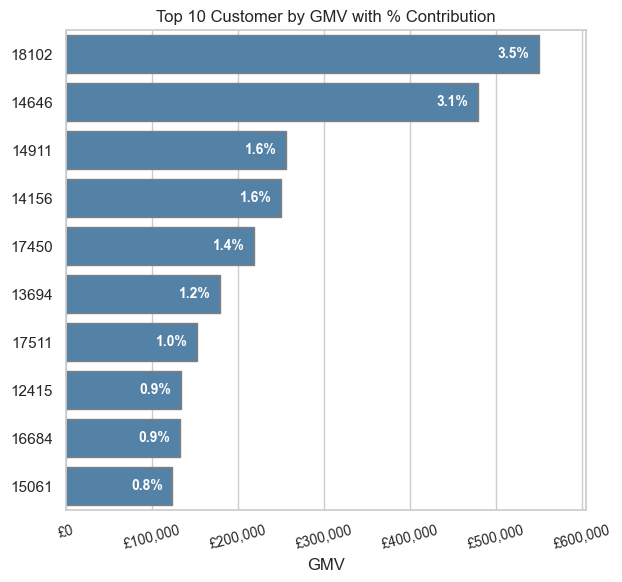

In [25]:
# Ambil sales per country menggunakan adjusted gmv
per_customer_sales = (
    df.groupby('customer_id')
      .agg(gmv=('adjusted_gmv', 'sum'))
      .reset_index()
)
# Hitung total gmv
total_gmv = per_customer_sales['gmv'].sum()

# Hitung persentase kontribusi ke total
per_customer_sales['pct'] = per_customer_sales['gmv'] / total_gmv * 100

# Ambil top 10
per_customer_sales = (
    per_customer_sales
      .sort_values('gmv', ascending=False)
      .head(10)
      .reset_index(drop=True)
)

# Convert customer_id to category
per_customer_sales['customer_id'] = per_customer_sales['customer_id'].astype('str')

# Plot dalam horizontal bar chat (x = gmv, y = sku_name)
fig, ax = plt.subplots(figsize=(8, 6))
bars = sns.barplot(
    data=per_customer_sales,
    x='gmv',
    y='customer_id',
    color='steelblue',
    ax=ax,
    edgecolor='gray'
)

# Axis formatting
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}'))
ax.tick_params(axis='x', labelsize=10, rotation=15)
ax.set_xlabel('GMV')
ax.set_ylabel('')
ax.set_title('Top 10 Customer by GMV with % Contribution')

# Extend x‑limit untuk label
max_gmv = per_customer_sales['gmv'].max()
ax.set_xlim(0, max_gmv * 1.1)

# Annotate persentase kontribusi ke masing masing bar chart
for bar, pct in zip(ax.patches, per_customer_sales['pct']):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(
        width - (max_gmv * 0.02), 
        y,
        f"{pct:.1f}%",
        ha='right',
        va='center',
        color='white',
        fontsize=10,
        fontweight='bold'
    )

# Adjustment margin
fig.subplots_adjust(left=0.30, right=0.95, top=0.90, bottom=0.10)

plt.show()


Cukup menarik, ada customer yang punya spending sangat tinggi, dia berkontribusi ke 3.5% sales

## Lost Sales

Pada deskripsi data, kita dapat info bahwa ada order yang dicancel. Hal yang bisa jadi poin of interestnya adalah:
- Berapa banyak sales yang lost akibat cancellation?
- Produk atau negara mana yang rentan terhadap cancellation?

In [26]:
# cek lost sales (order yg di cancel)
print("Lost Sales:",df[df['order_id_cancelled']]['adjusted_gmv'].sum())

Lost Sales: -1216112.0559999999


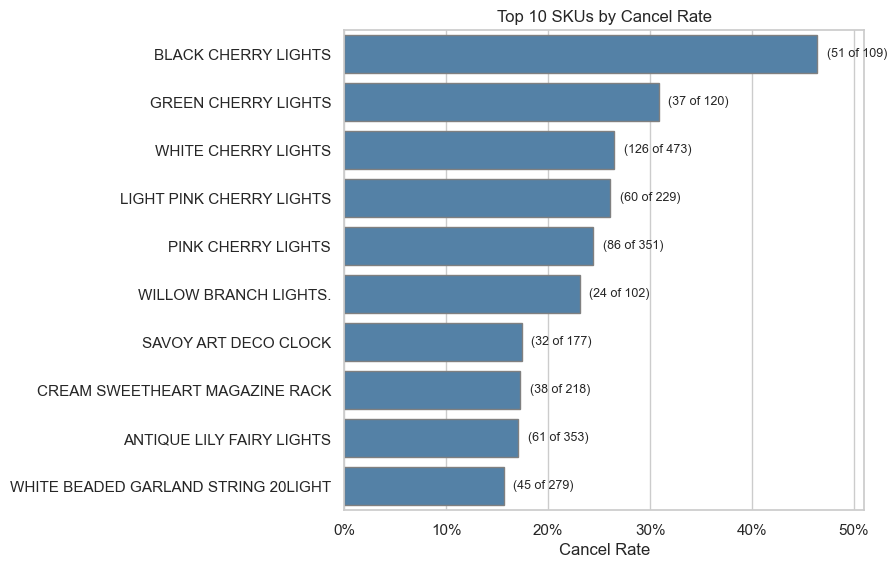

In [27]:
# hitung cancel percentage, total order & count cancellation per product
per_product_cancel = (
    df[~df['sku_id_no_digit']].groupby('sku_name') # Exclude SKU no digit
      .agg(
          cancel_percentage=('order_id_cancelled', 'mean'),
          total_order=('order_id', 'nunique'),
          cancelled_count=('order_id_cancelled', 'sum')
      )
      .reset_index()
)

# Take out low sales sku_id, ambil top 10 by cancel_percentge
per_product_cancel = (
    per_product_cancel[per_product_cancel['total_order'] >= 100]
      .sort_values(['cancel_percentage', 'total_order'], ascending=[False, False])
      .head(10)
      .reset_index(drop=True)
)

# Barplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    data=per_product_cancel,
    x='cancel_percentage',
    y='sku_name',
    color='steelblue',
    ax=ax,
    edgecolor='gray'
)

# Set x‐axis sebagai persentase
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Pelebaran xlim untuk annotation
max_pct = per_product_cancel['cancel_percentage'].max()
ax.set_xlim(0, max_pct * 1.1)

# Annotatation "(cancelled of total)"
for bar, cancelled, total in zip(ax.patches,
                                per_product_cancel['cancelled_count'],
                                per_product_cancel['total_order']):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(
        width + max_pct * 0.02,      
        y,
        f"({int(cancelled)} of {int(total)})",
        va='center',
        ha='left',
        fontsize=9
    )

# 7. Labels & layout
ax.set_xlabel('Cancel Rate')
ax.set_ylabel('')
ax.set_title('Top 10 SKUs by Cancel Rate')
fig.subplots_adjust(left=0.30, right=0.95, top=0.90, bottom=0.10)

plt.show()

Terdapat sku-sku yang memiliki cancellation rate yang tinggi, bahkan sampai 50%, perlu ditelusuri penyebab cancellation order tersebut (Mayoritas barang pecah belah)

## Sales Seasonality

Salah satu topik klasik adalah kapan sales kita mencapai peak? di bulan apa saja? kita dapat menggambarkan itu

Untuk menggambarkan tren sales bulanan, perlu kita cek range data terlebih dahulu

In [28]:
# cek series min dan max date
print('Min order_date:',df['order_date'].min())
print('Max order_date:',df['order_date'].max())

Min order_date: 2009-12-01 07:45:00
Max order_date: 2011-12-09 12:50:00


Karena order date terakhir di tanggal 9, kita harus hati hati dalam agregasi bulanan karena desember 2011 belum selesai

In [29]:
# Truncate tanggal jadi awal bulan
df['order_date_month'] = df['order_date'].dt.to_period('M').dt.to_timestamp()

# Exclude desember 2011, dan hitung sales bulanan
agg_month = df[df['order_date_month']<'2011-12-01'].groupby('order_date_month').agg({'adjusted_gmv':'sum'}).reset_index()

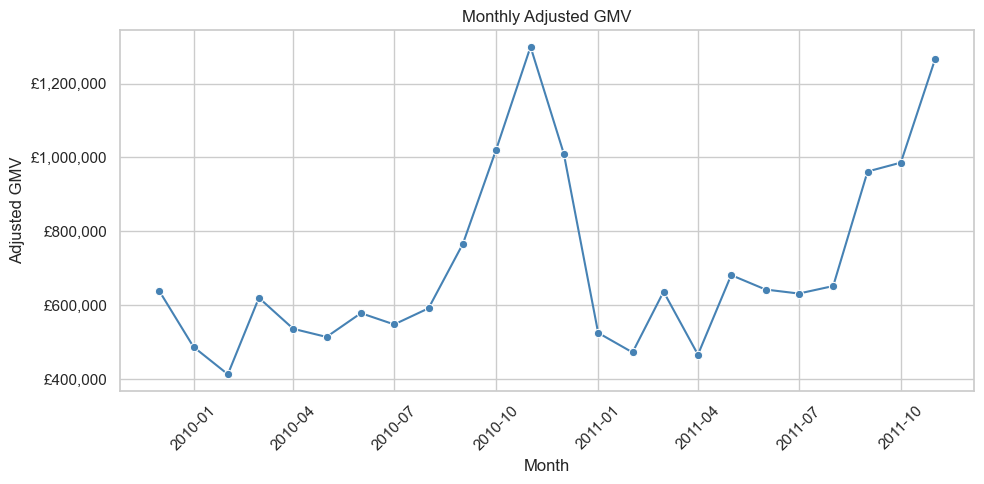

In [30]:
# Plot line chart utk adjusted gmv
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=agg_month,
    x='order_date_month',
    y='adjusted_gmv',
    marker='o',
    ax=ax,
    color='steelblue'
)

# Format yaxis dengan currency
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}'))

# Format xlabel, ylabel, title
ax.set_title('Monthly Adjusted GMV')
ax.set_xlabel('Month')
ax.set_ylabel('Adjusted GMV')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Kita dapat lihat bahwa sales selalu peak menjelang November, lalu drop

Pertanyaannya adalah, apakah toko memang libur?

In [31]:
# Buat full date range
full_dates = pd.date_range(df['order_date'].min(), df['order_date'].max(), freq='D')

# Extract date
full_dates = full_dates.date

# Ambil date yang ada di data
present_dates = df['order_date'].dt.date.unique()

# cari missing date
missing_dates = sorted(set(full_dates) - set(present_dates))

# Convert missing date ke dataframe
missing_dates_df = pd.DataFrame(missing_dates, columns=['missing_date'])

# tambahkan kolom day_of_week untuk missing date
missing_dates_df['day_of_week'] = missing_dates_df['missing_date'].apply(lambda x: x.strftime('%A'))

# Exclude missing date pada hari sabtu (karena kita tau pada hari sabtu, toko tutup)
missing_dates_df[missing_dates_df['day_of_week']!='Saturday']

,missing_date,day_of_week
2,2009-12-24,Thursday
3,2009-12-25,Friday
5,2009-12-27,Sunday
6,2009-12-28,Monday
7,2009-12-29,Tuesday
8,2009-12-30,Wednesday
9,2009-12-31,Thursday
10,2010-01-01,Friday
12,2010-01-03,Sunday
25,2010-04-02,Friday


Hari libur terjadi mendekati natal dan tahun baru, namum tidak menjelaskan kenapa bulan januari dan februari punya low sales

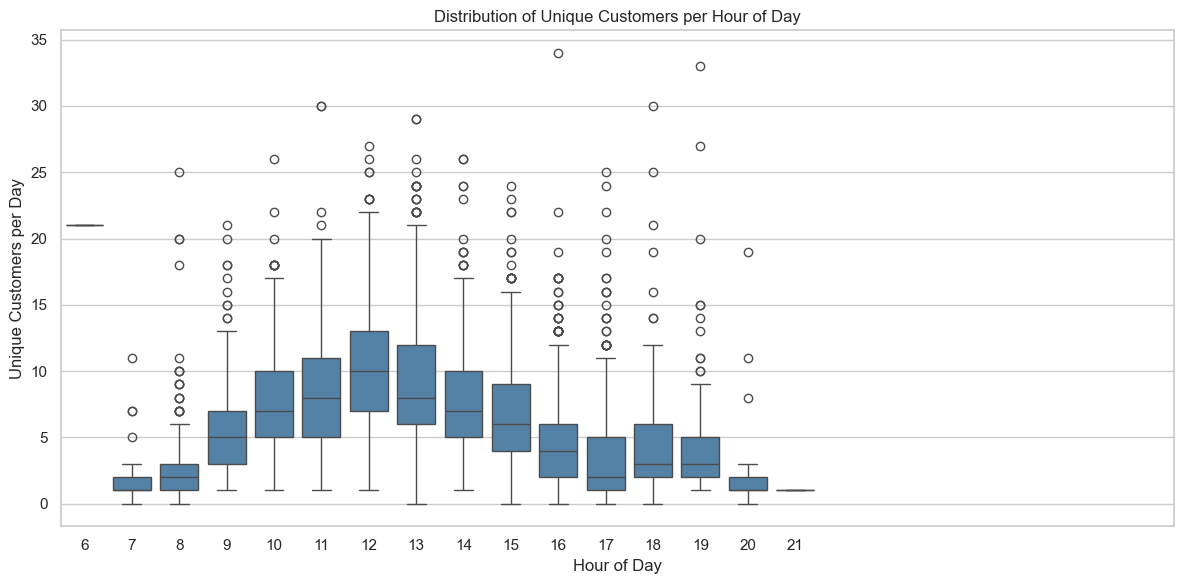

In [32]:
# Extract tanggal saja tanpa jam
df['order_date_only'] = df['order_date'].dt.date

# Hitung unique customer per tanggal dan per jam
per_hour = (
    df
    .groupby(['order_date_only', 'order_hour'])
    .agg(unique_customers=('customer_id', 'nunique'))
    .reset_index()
)

# boxplot untuk setiap jam pembelian
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=per_hour,
    x='order_hour',
    y='unique_customers',
    color='steelblue'
)

plt.title('Distribution of Unique Customers per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Unique Customers per Day')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


Sebagian besar customer belanja di siang hari

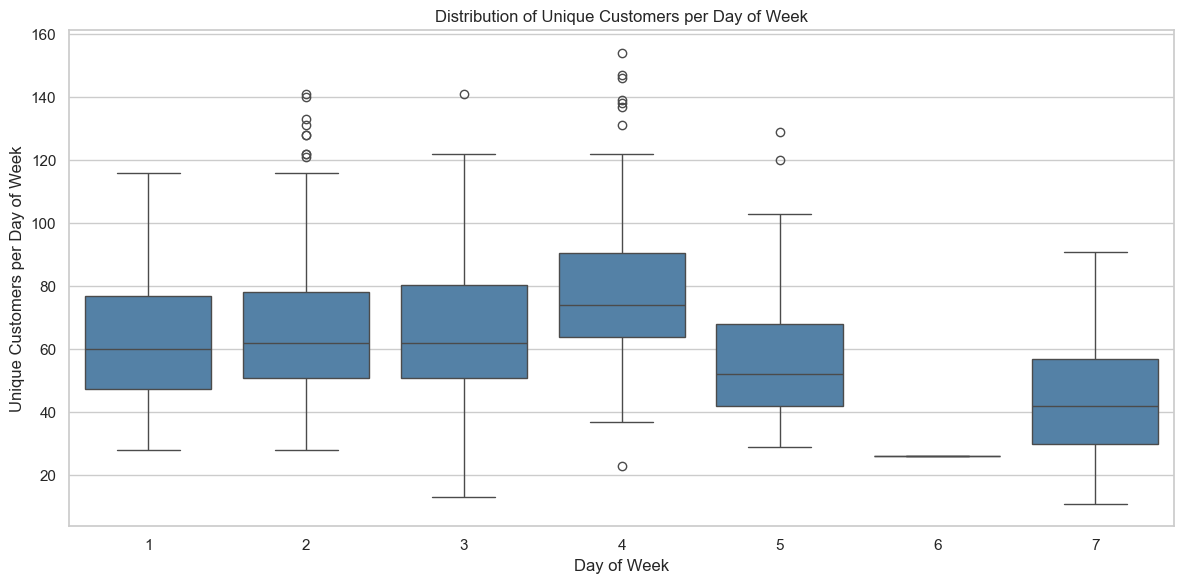

In [33]:
# Hitung unique customer per tanggal dan per hari dalam minggu
per_dayofweek = (
    df
    .groupby(['order_date_only', 'order_dayofweek'])
    .agg(unique_customers=('customer_id', 'nunique'))
    .reset_index()
)

# boxplot untuk day of week
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=per_dayofweek,
    x='order_dayofweek',
    y='unique_customers',
    color='steelblue'
)

plt.title('Distribution of Unique Customers per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Unique Customers per Day of Week')
plt.xticks(range(0, 7))
plt.tight_layout()
plt.show()


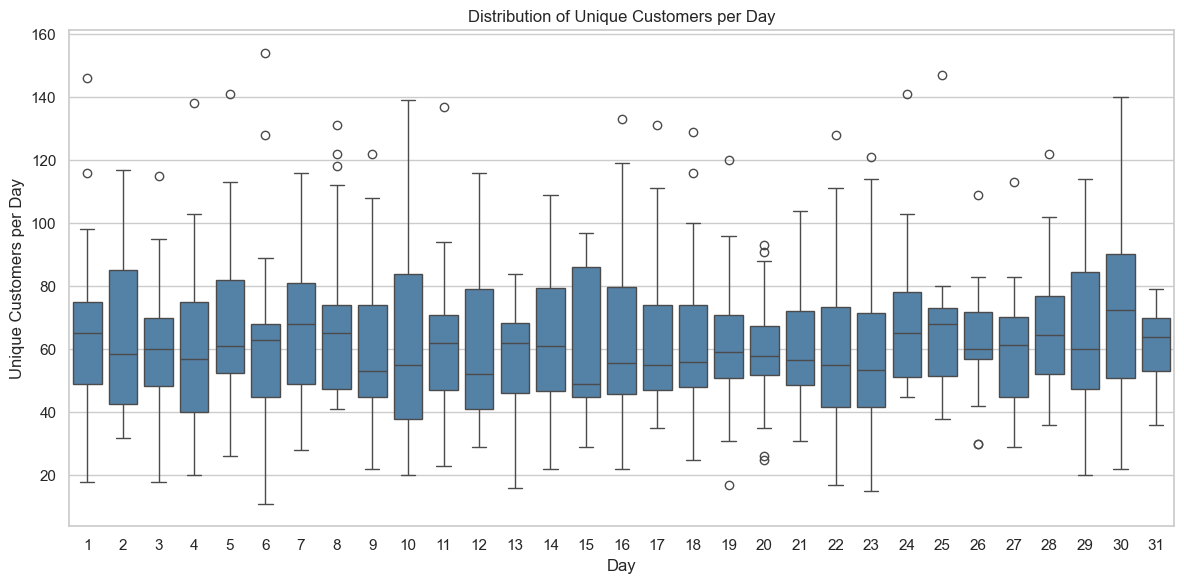

In [34]:
# Hitung unique customer per tanggal (dalam bulan)
per_day = (
    df
    .groupby(['order_date_only', 'order_day'])
    .agg(unique_customers=('customer_id', 'nunique'))
    .reset_index()
)

# Boxplot unique customer per tanggal
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=per_day,
    x='order_day',
    y='unique_customers',
    color='steelblue'
)

plt.title('Distribution of Unique Customers per Day')
plt.xlabel('Day')
plt.ylabel('Unique Customers per Day')
plt.xticks(range(0, 31))
plt.tight_layout()
plt.show()


Tidak ada pattern tertentu untuk hari pembelian (tidak ada surge akhir bulan saat tanggal gajian)

## Correlation Heatmap

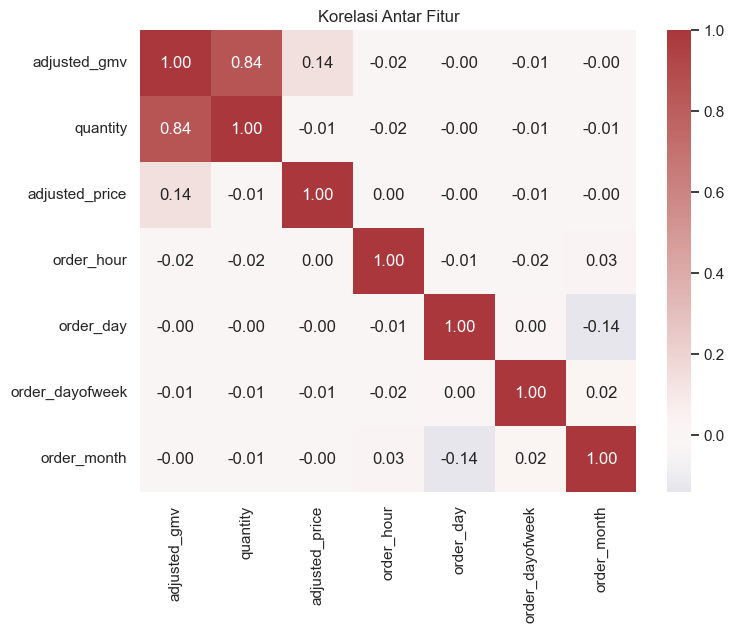

In [35]:
# Plot korelasi fitur numeric
corr_df = df[~df['order_id_cancelled']][['adjusted_gmv','quantity','adjusted_price','order_hour','order_day','order_dayofweek','order_month']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Korelasi Antar Fitur")
plt.show()

Secara korelasi, hanya:
- Quantity yang berkorelasi positif dengan GMV, namun itu harusnya sudah obvious, karena GMV adalah price * quantity
- Namun hal yang menariknya adalah, walaupu GMV = price*quantity, hanya quantity yang berkorelasi tinggi dengan GMV, price tidak

# Wrap Up

Dari sini, kita masih punya banyak hal yang di eksplor, misal:
- Price Elasticity
- Forecasting Sales
- Market Basket atau Recommendation System
- RFM Analysis
- Cohort / Churn Analysis
- Fraud Analysis
- Product Grouping

Beberapa hal tersebut akan kita eksplor di notebook selanjutnya

In [36]:
# Convert ke parquet
df.to_parquet('data/preprocessed/cleaned_data.parquet')